<a href="https://colab.research.google.com/github/anyavoitovich/data_science/blob/main/HW1/written_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/anyavoitovich/data_science/blob/main/written_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycaret


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.9/485.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 20.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.6 MB

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import os
from PIL import Image
import zipfile

# Уменьшение размера изображений до 100x100 пикселей
def load_and_resize_image(image_path, target_size=(28, 28)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Функция для преобразования изображения в массив NumPy
def image_to_array(img):
    return np.array(img)

# Функция для выравнивания и нормализации массива изображения
def flatten_and_normalize(img_array):
    flat_array = img_array.flatten()
    normalized_array = flat_array / 255.0  # предполагается, что значения пикселей находятся в диапазоне [0, 255]
    return normalized_array

# Путь к zip файлу на Google Drive
zip_path = '/content/drive/MyDrive/dataset.zip'

# Распаковка zip файла
extract_path = '/content/extracted'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Путь к папкам с изображениями (в данном случае в папках с цифрами)
images_root_folder = os.path.join(extract_path, 'dataset')

# Обработка данных
batch_size = 1000
data = []
for digit_folder in os.listdir(images_root_folder):
    digit_path = os.path.join(images_root_folder, digit_folder, digit_folder)
    if digit_folder == '.DS_Store' or not os.path.isdir(digit_path):
        continue
    image_files = [f for f in os.listdir(digit_path) if f.endswith('.png')]
    for i in range(0, len(image_files), batch_size):
        batch_files = image_files[i:i+batch_size]
        batch_data = []
        for image_file in batch_files:
            image_path = os.path.join(digit_path, image_file)
            img = load_and_resize_image(image_path)
            img_array = image_to_array(img)
            processed_array = flatten_and_normalize(img_array)
            batch_data.append([processed_array, digit_folder])
        data.extend(batch_data)

# Создание DataFrame с обработанными данными изображений
df = pd.DataFrame(data, columns=['image_array', 'digit_folder'])

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(df['image_array'].to_list(), df['digit_folder'], test_size=0.3, random_state=42)

# Преобразование меток в числа
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Создание и пошаговое обучение модели
model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Обучение на каждом батче
for X_batch, y_batch in zip(np.array_split(X_train, len(X_train)//batch_size), np.array_split(y_train_encoded, len(X_train)//batch_size)):
    model.fit(X_batch, y_batch)

# Прогнозы на тестовом наборе
y_pred = model.predict(X_test)

# Оценка модели
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred))

# Визуализация confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)
print("Confusion Matrix:")
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      3225
           1       0.83      0.99      0.91      3342
           2       0.90      0.87      0.88      3225
           3       0.84      0.82      0.83      3266
           4       0.89      0.73      0.81      3212
           5       0.85      0.77      0.81      3220
           6       0.77      0.88      0.82      3158
           7       0.85      0.89      0.87      3199
           8       0.92      0.88      0.90      3218
           9       0.85      0.82      0.83      3254

    accuracy                           0.86     32319
   macro avg       0.86      0.86      0.86     32319
weighted avg       0.86      0.86      0.86     32319

Confusion Matrix:
[[2919   59   29   11    2   79   46   10    4   66]
 [   0 3322    0    9    0    0    0   11    0    0]
 [  56   77 2797   93   30   11   44  102    7    8]
 [   0   57   73 2682    0  125   11  202

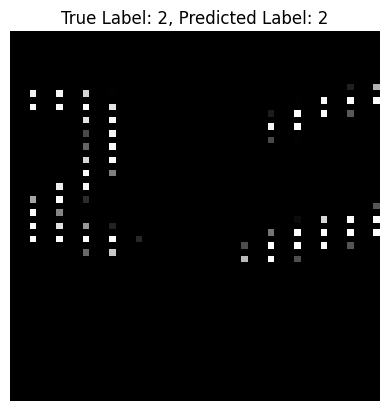

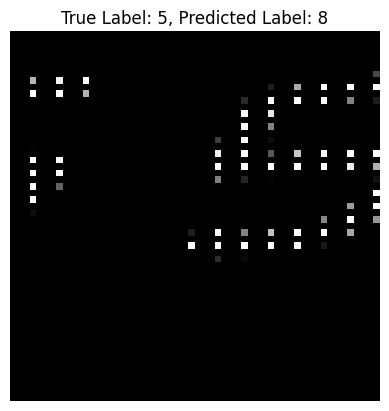

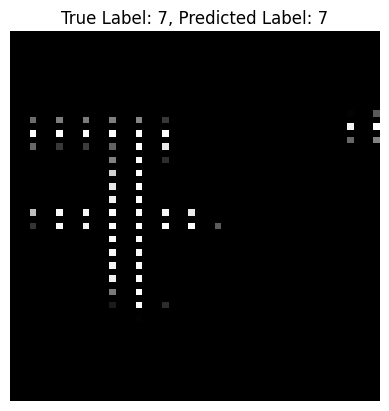

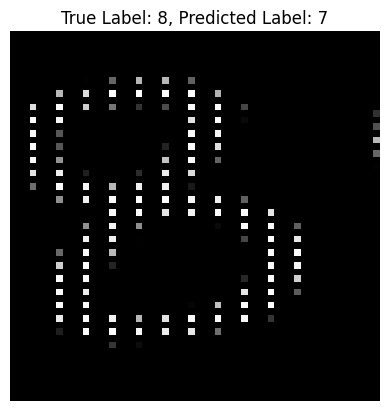

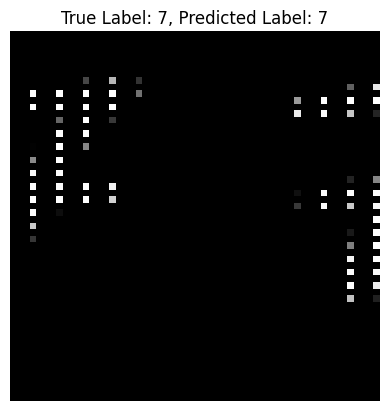

In [9]:
import matplotlib.pyplot as plt
import random

# Выберем случайные изображения из тестового набора
sample_indices = random.sample(range(len(X_test)), 5)

# Отобразим изображения и предсказания
for idx in sample_indices:
    image_array = np.array(X_test[idx])
    digit_folder = le.inverse_transform([y_test_encoded[idx]])[0]
    predicted_digit = le.inverse_transform([y_pred[idx]])[0]

    # Проверим форму изображения
    if len(image_array.shape) == 1 and image_array.size == 3136:
        # Если форма (3136,), предполагаем, что изображение было выровнено и восстанавливаем его форму (56, 56)
        image_array = image_array.reshape((56, 56))  # Предположим, что изображение было уменьшено в 2 раза

    # Преобразуем значения пикселей обратно в [0, 255], чтобы избежать проблем с отображением
    image_array = (image_array * 255).astype('uint8')

    plt.imshow(image_array, cmap='gray')
    plt.title(f"True Label: {digit_folder}, Predicted Label: {predicted_digit}")
    plt.axis('off')
    plt.show()


In [ ]:
!free -m


               total        used        free      shared  buff/cache   available
Mem:           12978        1119       10867           3         991       11564
Swap:              0           0           0
